## Importing Required Libraries

In [2]:
import pandas as pd
import numpy as np
import re
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from datetime import datetime
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from bertopic import BERTopic
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.metrics import silhouette_score

## Downloading NLTK Resources

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /Users/sila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sila/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/sila/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Loading Data

In [6]:
df = pd.read_json("data.json", lines=True)
df.head()

link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

        date  
0 2022-09-23  
1 2022-09-23  
2 2022-09-23  
3 2022-09-23  
4 2022-09-22

## Cleaning and Preparing Data

In [8]:
df.drop(columns=['link', 'authors', 'category', 'headline'], inplace=True)
df.head()

short_description       date
0  Health experts said it is too early to predict... 2022-09-23
1  He was subdued by passengers and crew when he ... 2022-09-23
2  "Until you have a dog you don't understand wha... 2022-09-23
3  "Accidentally put grown-up toothpaste on my to... 2022-09-23
4  Amy Cooper accused investment firm Franklin Te... 2022-09-22

## Text Preprocessing

In [10]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)  #Remove Punctuation
    text = text.lower()  #onvert to lowercase
    tokens = word_tokenize(text)  #tokenize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Lemmatize & remove stopwords
    return ' '.join(tokens)

In [12]:
df['clean_text'] = df['short_description'].apply(preprocess_text)

df['year'] = pd.to_datetime(df['date'], errors='coerce').dt.year
df = df.dropna(subset=['year'])
df['year'] = df['year'].astype(int)

## Grouping Text Data by Year

In [14]:
grouped = df.groupby('year')['clean_text'].apply(' '.join).reset_index()

## Vectorizing Text Data

In [16]:
#Bag of Words
vectorizer_bow = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm_bow = vectorizer_bow.fit_transform(grouped['clean_text'])

In [17]:
#Tf-IDF
vectorizer_tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm_tfidf = vectorizer_tfidf.fit_transform(grouped['clean_text'])

In [18]:
bert_model = SentenceTransformer('all-MiniLM-L6-v2') 
bert_embeddings = bert_model.encode(grouped['clean_text'], show_progress_bar=False)

## Topic Modeling and Clustering Models

In [20]:
lsa_model = TruncatedSVD(n_components=5)
lsa_topics = lsa_model.fit_transform(dtm_tfidf) 

In [21]:
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda_model.fit_transform(dtm_bow)

In [22]:
nmf_model = NMF(n_components=5, random_state=42)
nmf_topics = nmf_model.fit_transform(dtm_tfidf)

In [23]:
num_clusters = 5 
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(dtm_tfidf)

KMeans(n_clusters=5, random_state=42)

In [24]:
bertopic_model = BERTopic()
topics, probs = bertopic_model.fit_transform(grouped['clean_text'])

## Analyzing and Visualizing Model Results

In [26]:
def analyze_and_plot_model_results(model, model_name, vectorizer, dtm, grouped, year_col='year', top_n=10):

    if model_name == "KMeans":
        feature_names = vectorizer.get_feature_names_out()
        order_centroids = model.cluster_centers_.argsort()[:, ::-1]
        labels = [
            f"Cluster {i + 1}: " + ", ".join([feature_names[idx] for idx in order_centroids[i, :top_n]])
            for i in range(model.n_clusters)
        ]
        grouped[f"{model_name}_label"] = model.labels_

    elif model_name in ["LSA", "LDA", "NMF"]:
        feature_names = vectorizer.get_feature_names_out()
        components = model.components_
        labels = [
            f"Topic {i + 1}: " + ", ".join([feature_names[j] for j in topic.argsort()[:-top_n - 1:-1]])
            for i, topic in enumerate(components)
        ]
        doc_topic_matrix = model.transform(dtm)
        grouped[f"{model_name}_label"] = doc_topic_matrix.argmax(axis=1)

    elif model_name == "BERTopic":
        topic_info = model.get_topic_info()
        labels = topic_info['Name'].to_list()
        doc_topic_matrix = pd.DataFrame(probs, columns=topic_labels).to_numpy()

    else:
        raise ValueError(f"Model {model_name} not supported.")

    grouped[f"{model_name}_label_name"] = grouped[f"{model_name}_label"].apply(lambda x: labels[x])

    if model_name in ["LSA", "LDA", "NMF", "BERTopic"]:
        trends_df = pd.DataFrame(doc_topic_matrix, columns=labels)
        trends_df[year_col] = grouped[year_col].values
        trends = trends_df.groupby(year_col).mean()

        try:
            trends.plot(figsize=(12, 8))
            plt.title(f"{model_name} Topic Trends Over Time")
            plt.xlabel("Year")
            plt.ylabel("Average Topic Proportion")
            plt.legend(title="Topics", loc='best')
            plt.show()
        except Exception as e:
            print(f"Error plotting topic trends: {e}")

    else:  #for Kmeans
        trends = grouped.groupby([year_col, f"{model_name}_label_name"]).size().unstack(fill_value=0)

        try:
            trends.plot(figsize=(12, 8))
            plt.title(f"{model_name} Trends Over Time")
            plt.xlabel("Year")
            plt.ylabel("Number of Documents")
            plt.legend(title="Labels", loc='best')
            plt.show()
        except Exception as e:
            print(f"Error plotting trends over time: {e}")

    try:
        dominant_labels = grouped.groupby([year_col, f"{model_name}_label_name"]).size().unstack(fill_value=0)
        dominant_labels.plot(kind='bar', stacked=True, figsize=(12, 8))
        plt.title(f"{model_name} Dominant Labels Over Time")
        plt.xlabel("Year")
        plt.ylabel("Number of Documents")
        plt.legend(title="Labels", loc='best', labels=labels)
        plt.show()
    except Exception as e:
        print(f"Error plotting dominant labels: {e}")

    print(f"Top terms per label for {model_name}:")
    for label in labels:
        print(label)

    #word cloud
    for i in range(len(labels)):
        if model_name == "KMeans":
            cluster_texts = " ".join(grouped[grouped[f"{model_name}_label"] == i]['clean_text'].dropna())
        else:
            cluster_texts = " ".join(grouped[grouped[f"{model_name}_label"] == i]['clean_text'].dropna())

        if not cluster_texts.strip():
            print(f"Skipping WordCloud for {model_name} Label {i} due to lack of text.")
            continue

        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(cluster_texts)
        plt.figure(figsize=(10, 5))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"WordCloud for {model_name} Label {i}")
        plt.show()


In [27]:
def analyze_and_plot_topic_trends_for_bert(model, model_name, dtm=None, vectorizer=None, grouped=None, year_col='year', top_n=5):
    #BERTopic
    topic_info = model.get_topic_info()
    topic_labels = topic_info['Name'].to_list()
    doc_topic_matrix = pd.DataFrame(probs, columns=topic_labels).to_numpy()
    
    #analyze trends over years
    trends_df = pd.DataFrame(doc_topic_matrix, columns=topic_labels)
    trends_df[year_col] = grouped[year_col].values
    topic_trends = trends_df.groupby(year_col).mean()
    
    #plot topic trends
    topic_trends.plot(figsize=(12, 8))
    plt.title(f"{model_name} Topic Trends Over Time")
    plt.xlabel("Year")
    plt.ylabel("Average Topic Proportion")
    plt.legend(title="Topics", loc='best')
    plt.show()
    
    #assign dominant topic label to each document
    grouped[f"{model_name}_dominant_topic"] = doc_topic_matrix.argmax(axis=1)
    grouped[f"{model_name}_dominant_topic_label"] = grouped[f"{model_name}_dominant_topic"].apply(
        lambda x: topic_labels[x]
    )
    
    #Analyze topic distribution over years
    topic_counts = grouped.groupby([year_col, f"{model_name}_dominant_topic_label"]).size().unstack(fill_value=0)
    
    #plot dominant topic frequency over time
    topic_counts.plot(kind='bar', stacked=True, figsize=(12, 8))
    plt.title(f"{model_name} Dominant Topics Over Time")
    plt.xlabel("Year")
    plt.ylabel("Number of Documents")
    plt.legend(title="Topics", loc='best')
    plt.show()

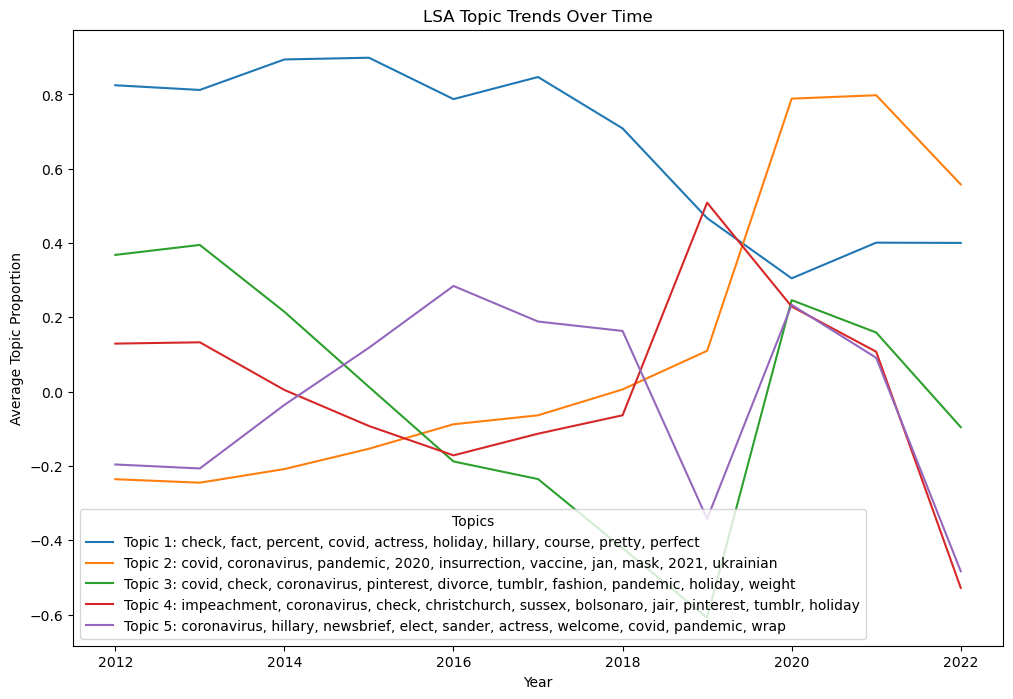

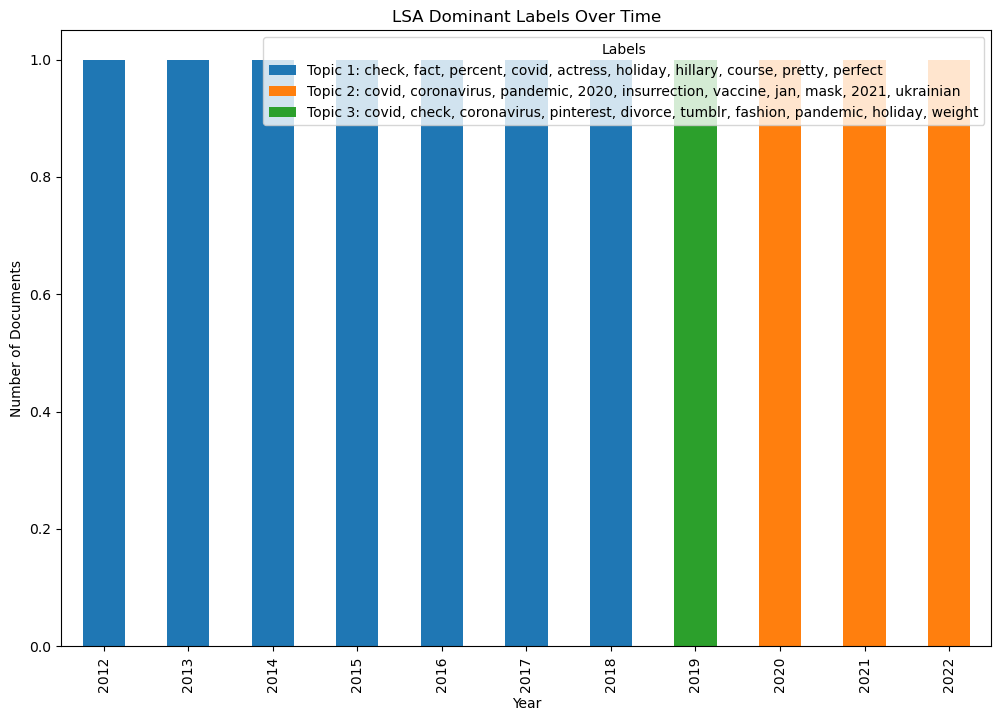

Top terms per label for LSA:
Topic 1: check, fact, percent, covid, actress, holiday, hillary, course, pretty, perfect
Topic 2: covid, coronavirus, pandemic, 2020, insurrection, vaccine, jan, mask, 2021, ukrainian
Topic 3: covid, check, coronavirus, pinterest, divorce, tumblr, fashion, pandemic, holiday, weight
Topic 4: impeachment, coronavirus, check, christchurch, sussex, bolsonaro, jair, pinterest, tumblr, holiday
Topic 5: coronavirus, hillary, newsbrief, elect, sander, actress, welcome, covid, pandemic, wrap


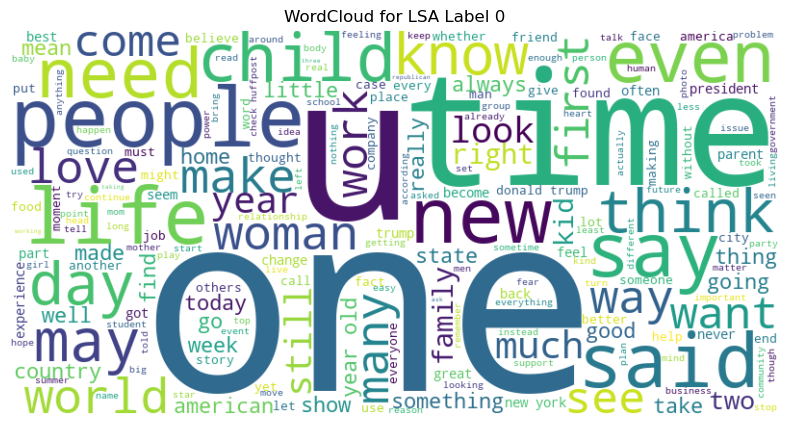

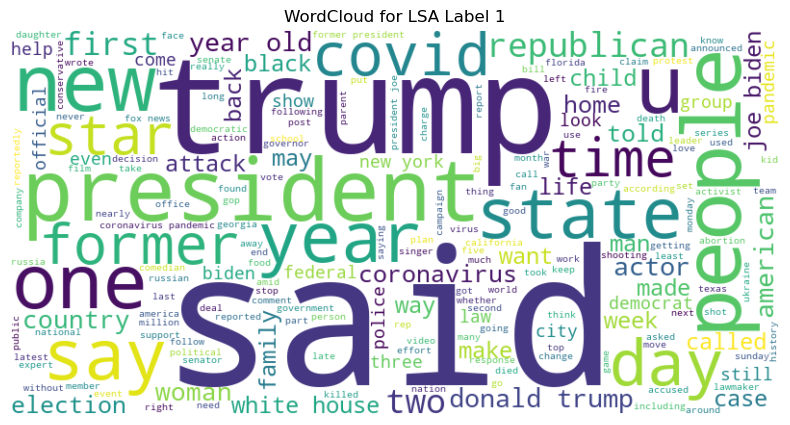

Skipping WordCloud for LSA Label 2 due to lack of text.


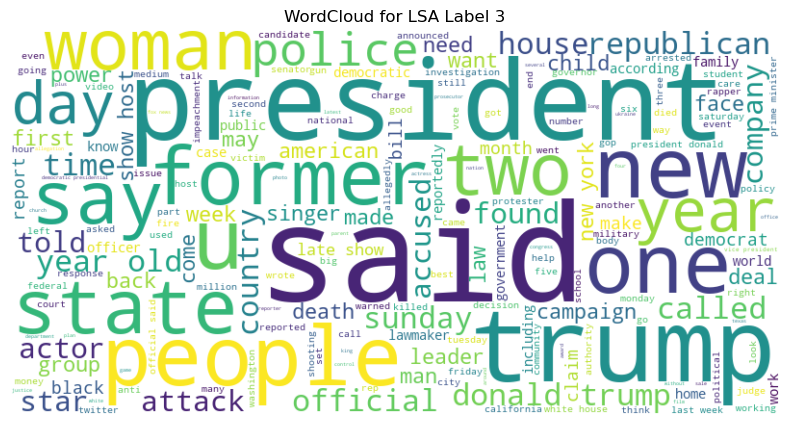

Skipping WordCloud for LSA Label 4 due to lack of text.


In [28]:
analyze_and_plot_model_results(
    model=lsa_model,  
    model_name="LSA", 
    vectorizer=vectorizer_tfidf,
    dtm=dtm_tfidf,
    grouped=grouped,
    year_col="year",
    top_n=10
)

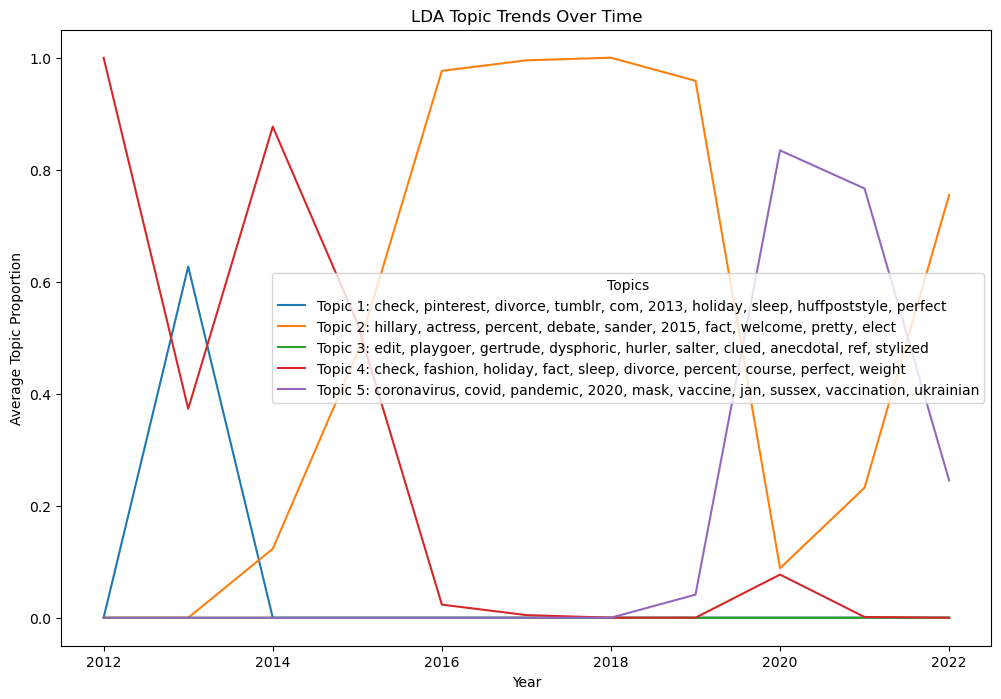

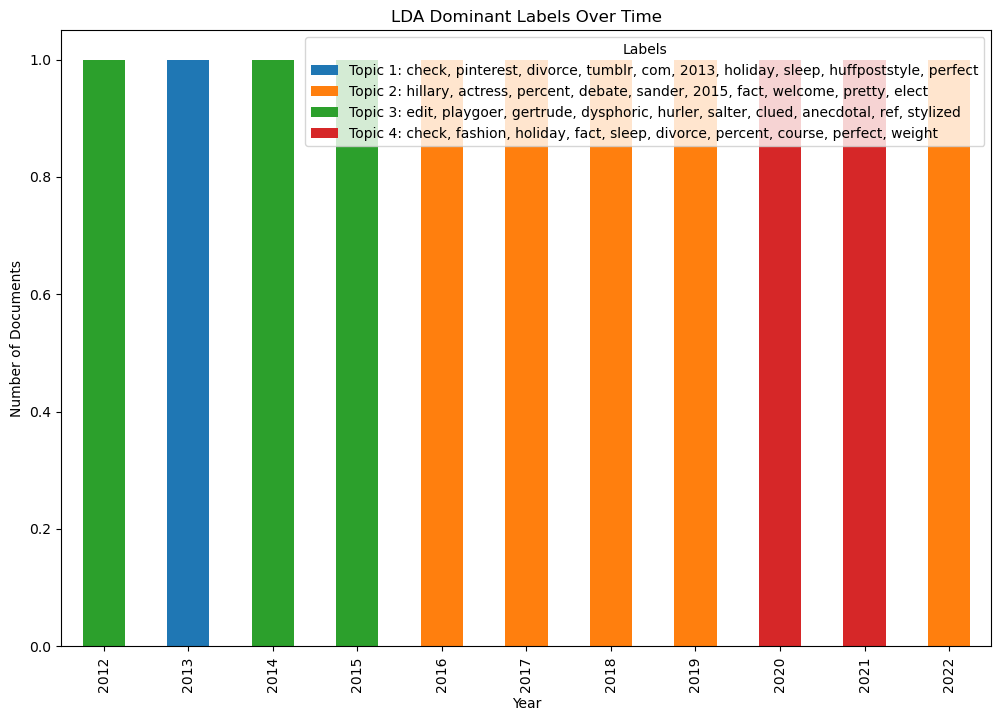

Top terms per label for LDA:
Topic 1: check, pinterest, divorce, tumblr, com, 2013, holiday, sleep, huffpoststyle, perfect
Topic 2: hillary, actress, percent, debate, sander, 2015, fact, welcome, pretty, elect
Topic 3: edit, playgoer, gertrude, dysphoric, hurler, salter, clued, anecdotal, ref, stylized
Topic 4: check, fashion, holiday, fact, sleep, divorce, percent, course, perfect, weight
Topic 5: coronavirus, covid, pandemic, 2020, mask, vaccine, jan, sussex, vaccination, ukrainian


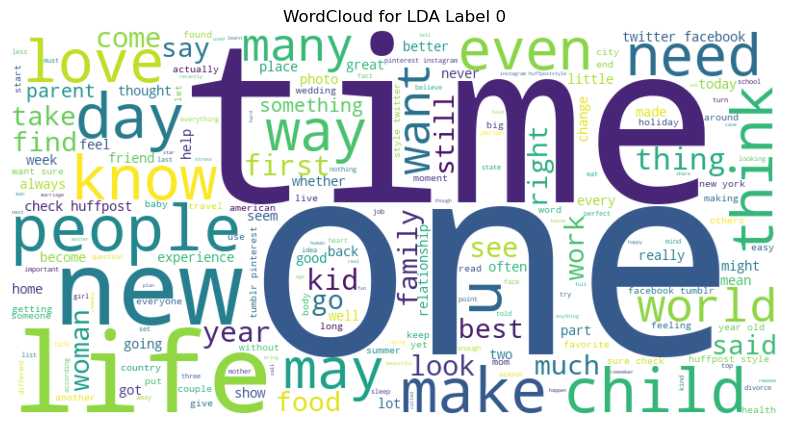

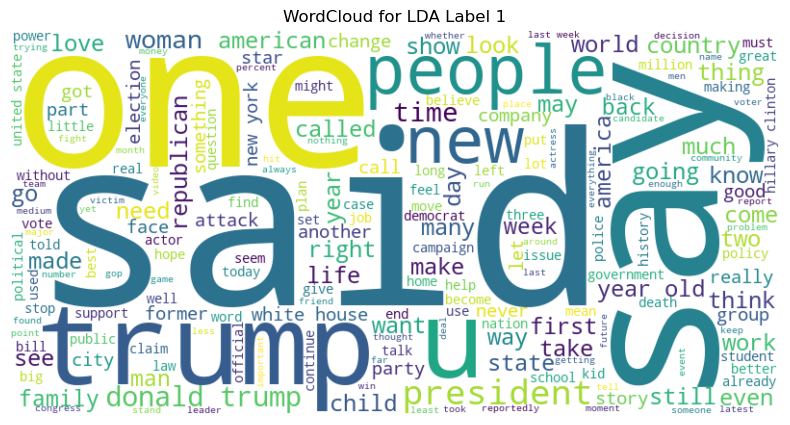

Skipping WordCloud for LDA Label 2 due to lack of text.


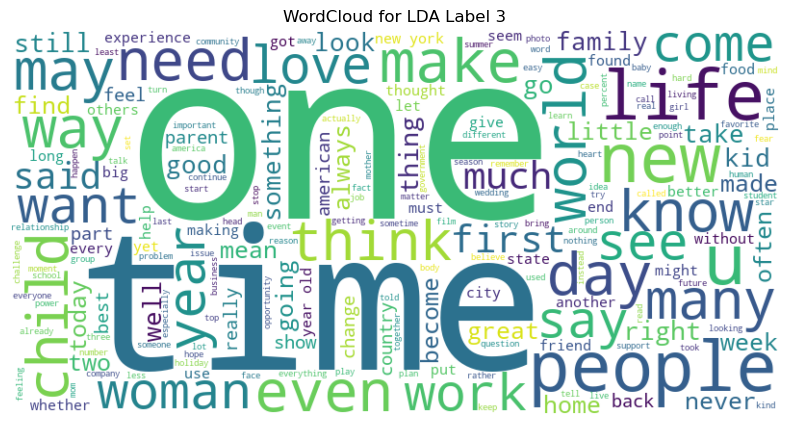

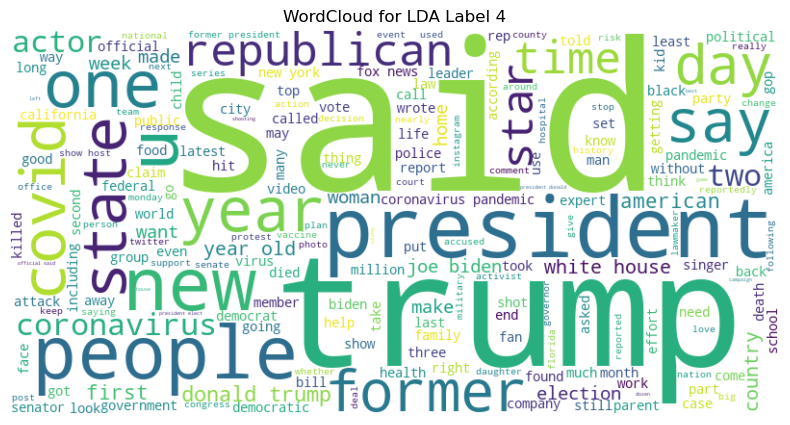

In [29]:
analyze_and_plot_model_results(
    model=lda_model, 
    model_name="LDA", 
    vectorizer=vectorizer_bow,
    dtm=dtm_bow,
    grouped=grouped,
    year_col="year",
    top_n=10
)

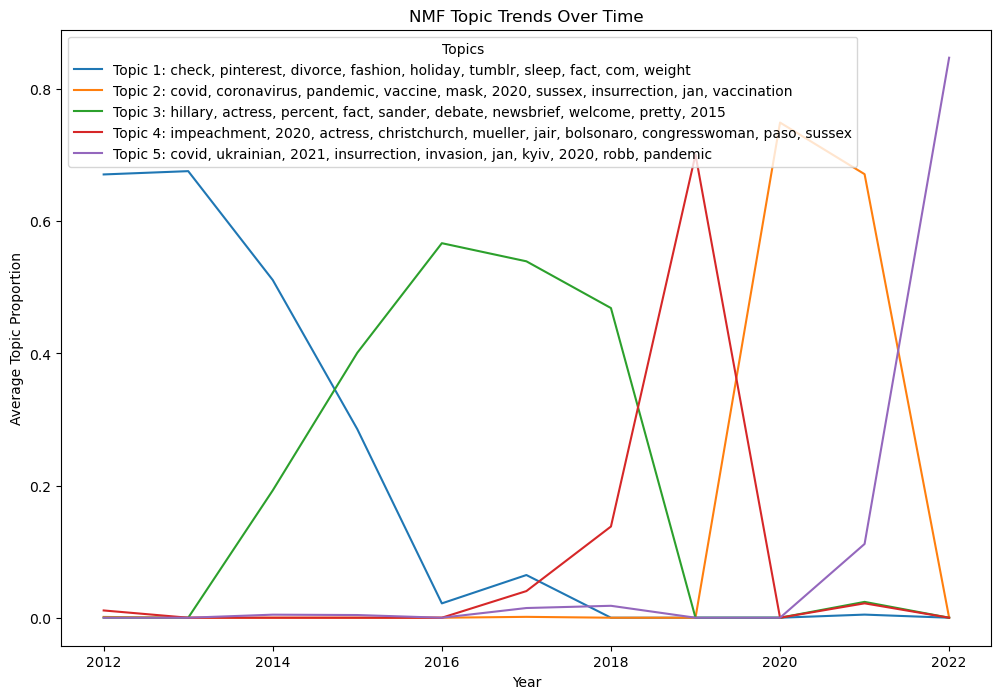

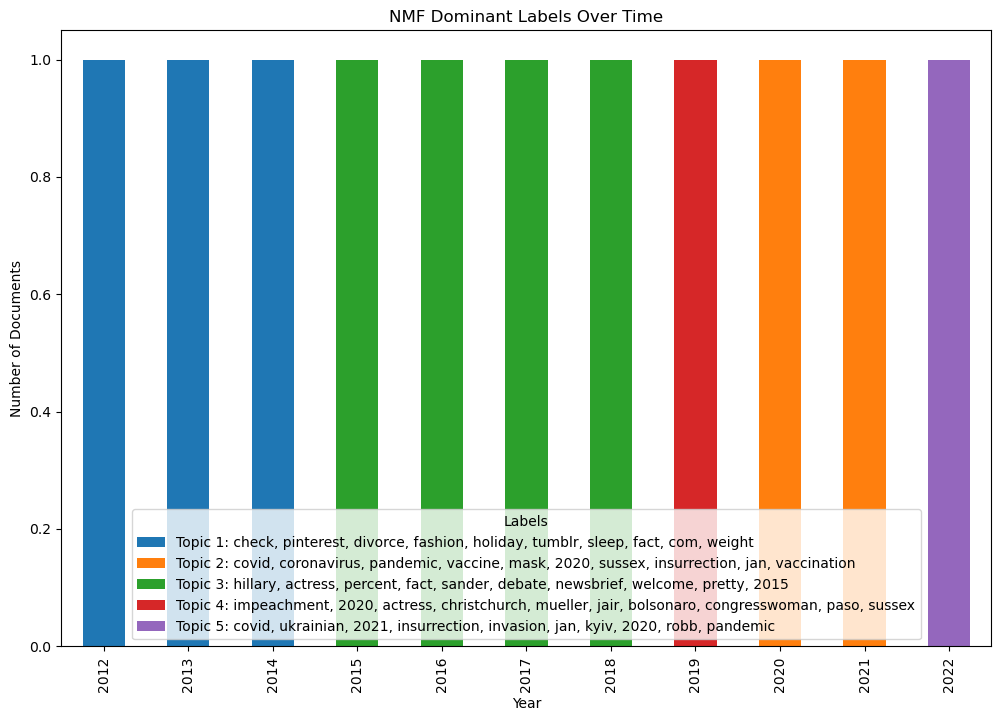

Top terms per label for NMF:
Topic 1: check, pinterest, divorce, fashion, holiday, tumblr, sleep, fact, com, weight
Topic 2: covid, coronavirus, pandemic, vaccine, mask, 2020, sussex, insurrection, jan, vaccination
Topic 3: hillary, actress, percent, fact, sander, debate, newsbrief, welcome, pretty, 2015
Topic 4: impeachment, 2020, actress, christchurch, mueller, jair, bolsonaro, congresswoman, paso, sussex
Topic 5: covid, ukrainian, 2021, insurrection, invasion, jan, kyiv, 2020, robb, pandemic


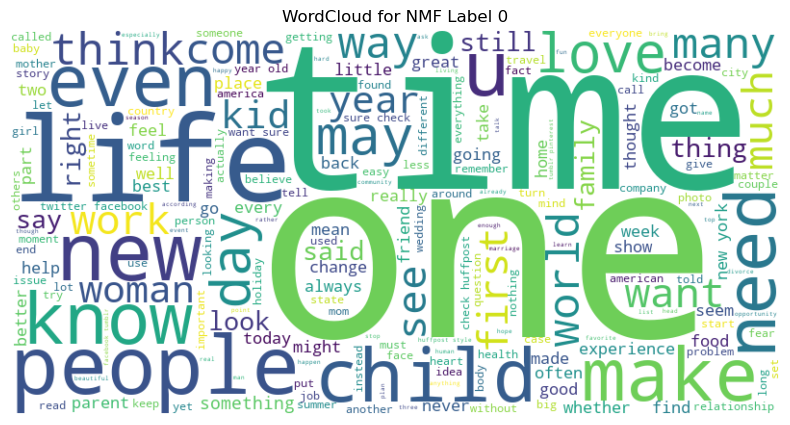

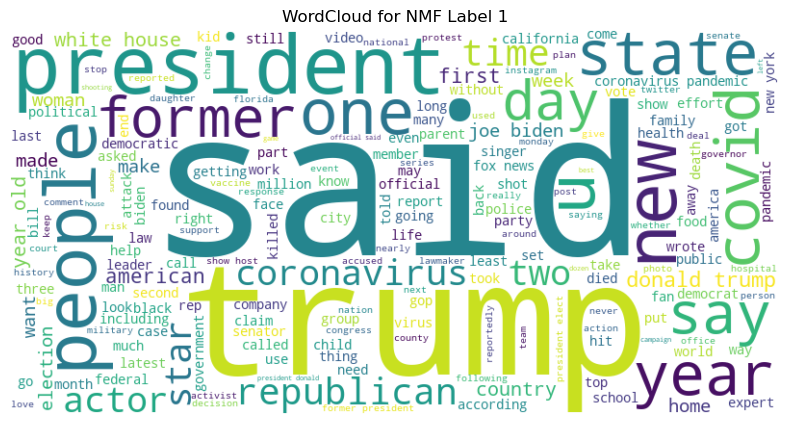

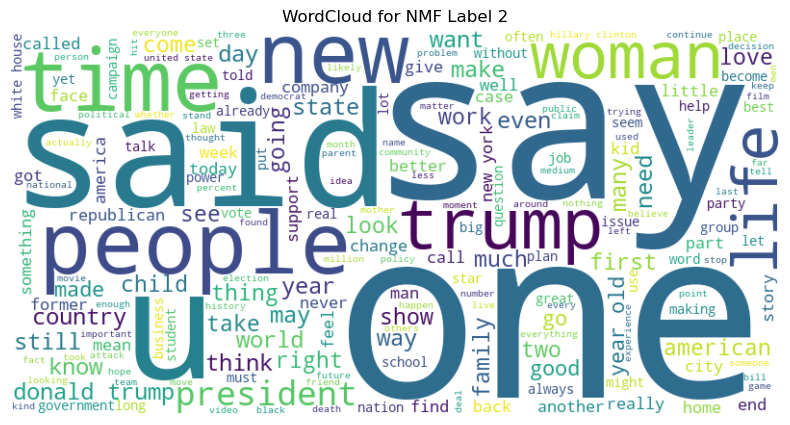

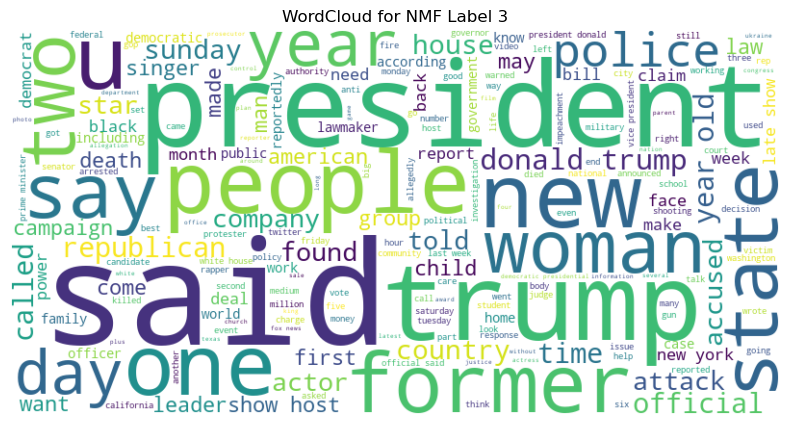

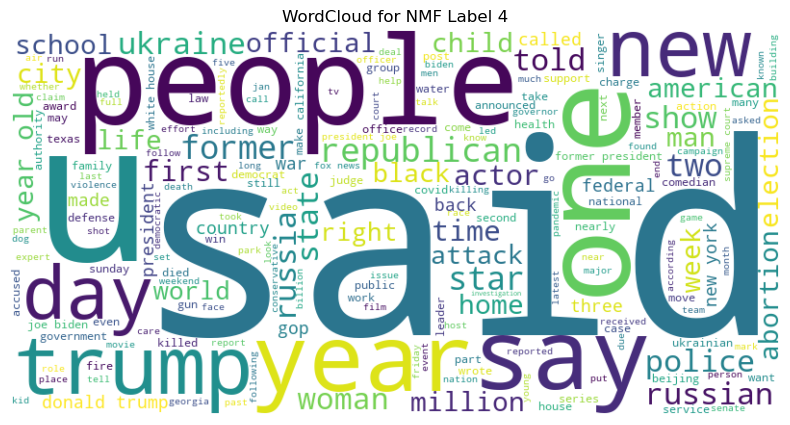

In [30]:
analyze_and_plot_model_results(
    model=nmf_model,  
    model_name="NMF", 
    vectorizer=vectorizer_tfidf,
    dtm=dtm_tfidf,
    grouped=grouped,
    year_col="year",
    top_n=10
)

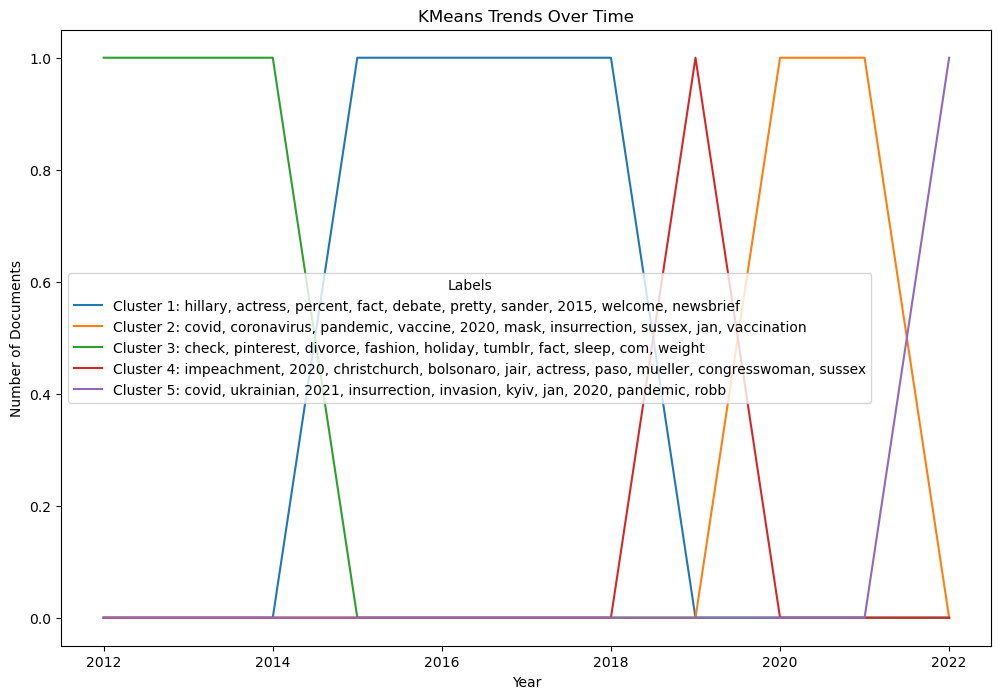

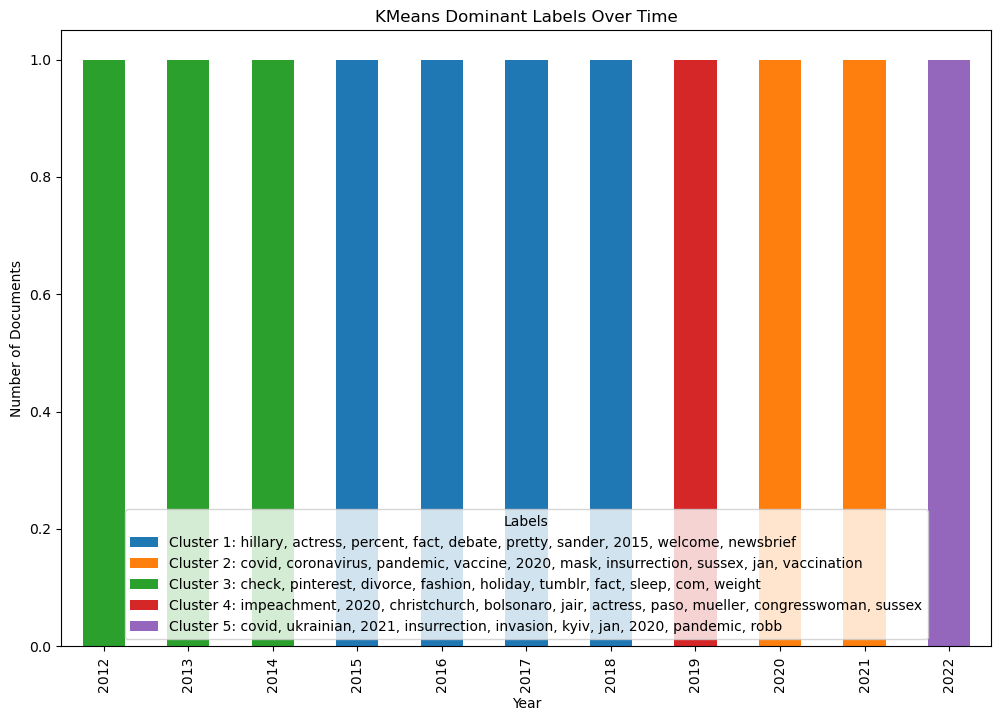

Top terms per label for KMeans:
Cluster 1: hillary, actress, percent, fact, debate, pretty, sander, 2015, welcome, newsbrief
Cluster 2: covid, coronavirus, pandemic, vaccine, 2020, mask, insurrection, sussex, jan, vaccination
Cluster 3: check, pinterest, divorce, fashion, holiday, tumblr, fact, sleep, com, weight
Cluster 4: impeachment, 2020, christchurch, bolsonaro, jair, actress, paso, mueller, congresswoman, sussex
Cluster 5: covid, ukrainian, 2021, insurrection, invasion, kyiv, jan, 2020, pandemic, robb


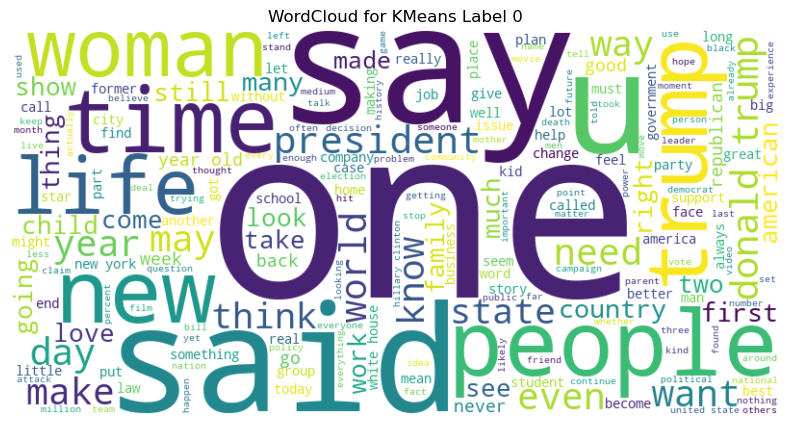

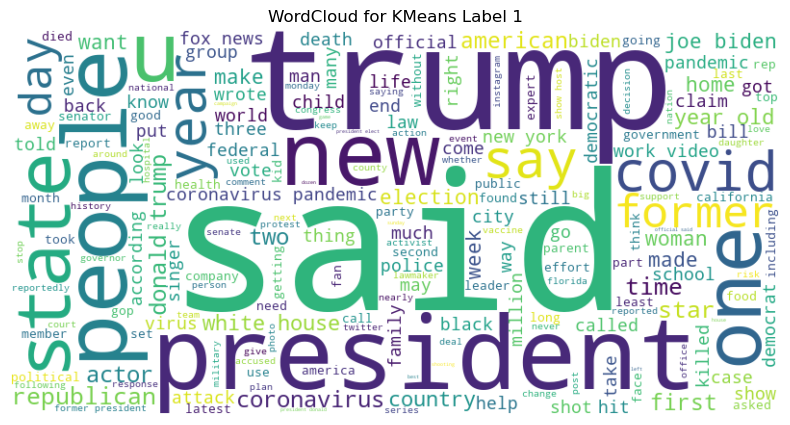

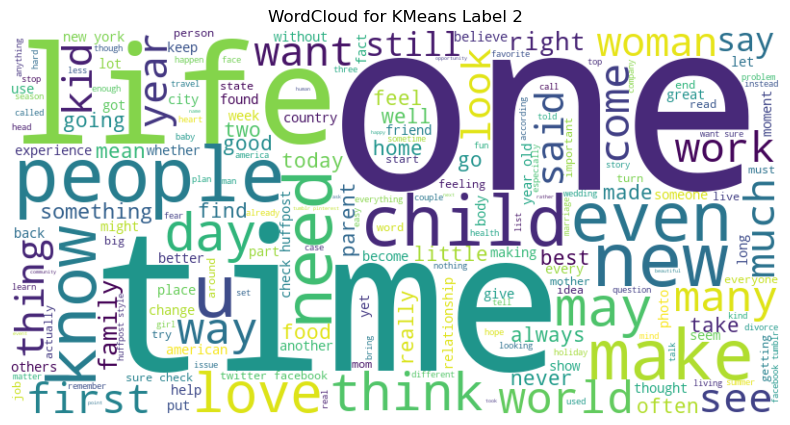

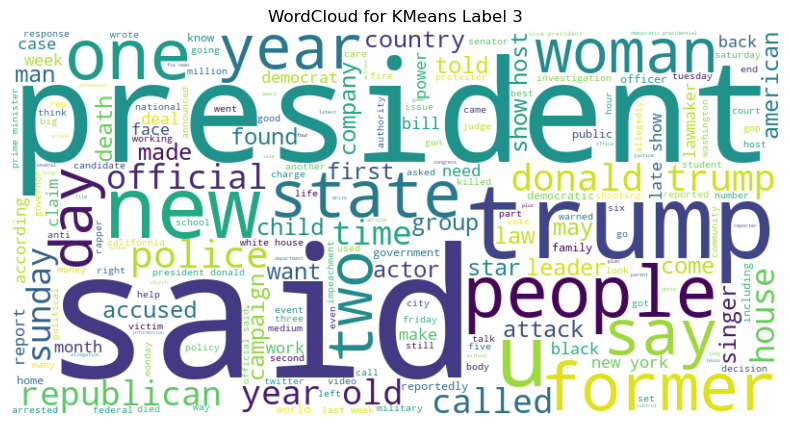

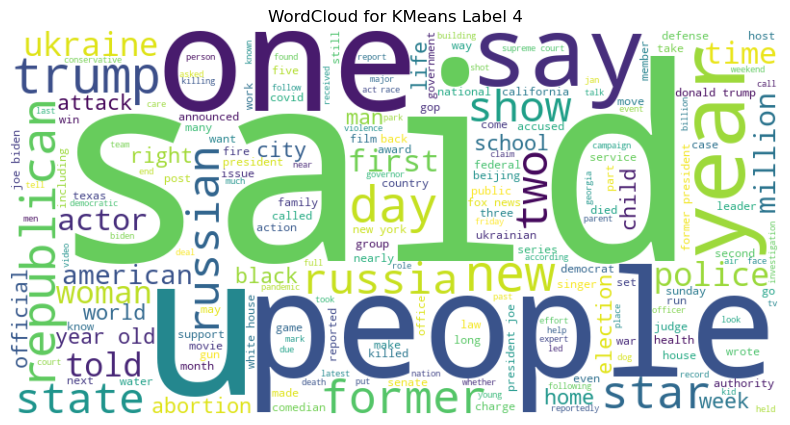

In [31]:
analyze_and_plot_model_results(
    model=kmeans,
    model_name="KMeans",
    vectorizer=vectorizer_tfidf,
    dtm=None,
    grouped=grouped,
    year_col="year",
    top_n=10
)

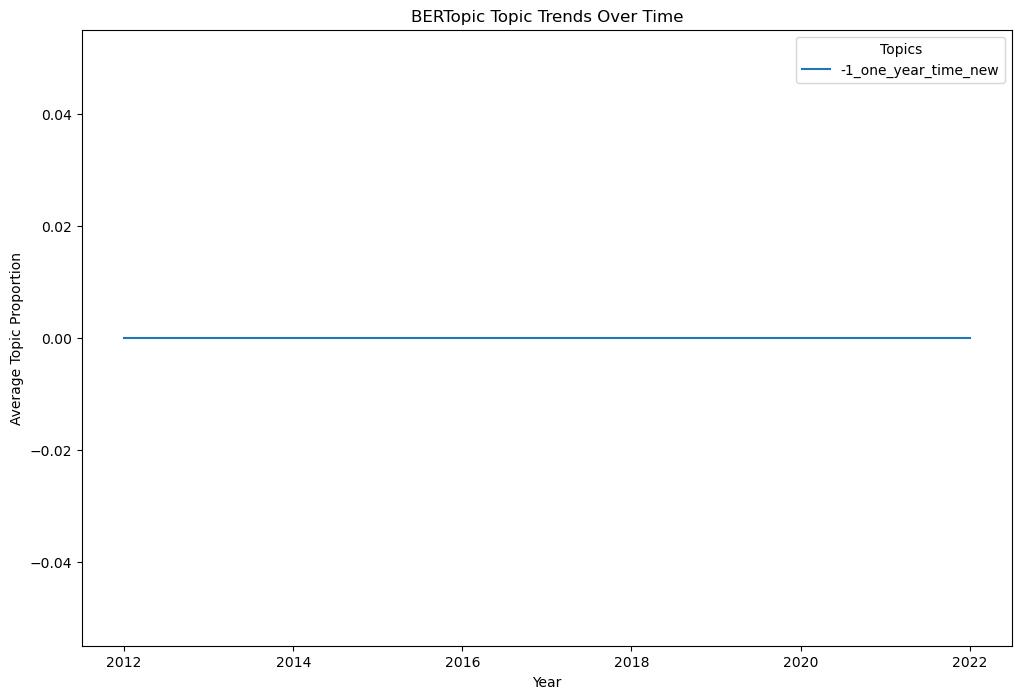

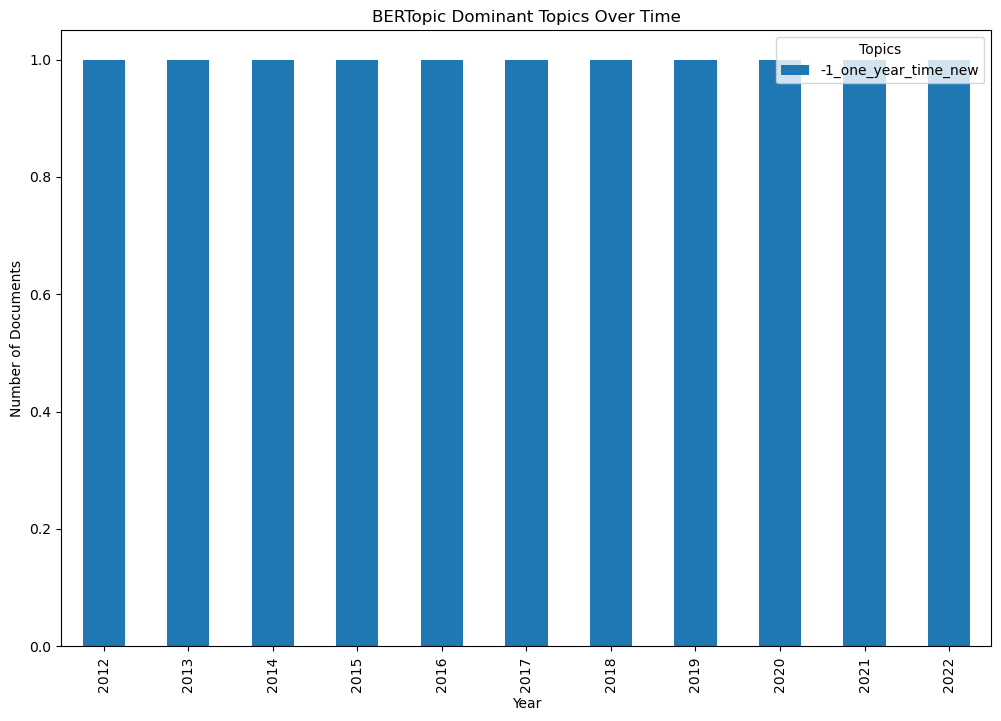

In [32]:
analyze_and_plot_topic_trends_for_bert(bertopic_model, "BERTopic", grouped=grouped)

## Tuning Model Performance for Clustering and Topic Modeling

In [34]:
def tune_model_performance(dtm, algorithm, n_range=range(2, 10), random_state=42):

    performance_scores = {}

    print(f"Tuning the number of clusters/topics for {algorithm}:")
    for n in n_range:
        if algorithm == 'LDA':
            model = LatentDirichletAllocation(n_components=n, random_state=random_state)
            model.fit(dtm)
            score = model.perplexity(dtm)
            print(f"Number of topics: {n}, Perplexity: {score:.2f}")

        elif algorithm == 'NMF':
            model = NMF(n_components=n, random_state=random_state, init='random')
            W = model.fit_transform(dtm)
            H = model.components_
            reconstruction_error = model.reconstruction_err_
            score = reconstruction_error
            print(f"Number of topics: {n}, Reconstruction Error: {score:.2f}")

        elif algorithm == 'LSA':
            model = TruncatedSVD(n_components=n, random_state=random_state)
            model.fit(dtm)
            explained_variance = model.explained_variance_ratio_.sum()
            score = explained_variance
            print(f"Number of topics: {n}, Explained Variance: {score:.2f}")

        elif algorithm == 'KMeans':
            model = KMeans(n_clusters=n, random_state=random_state, n_init=10)
            model.fit(dtm)
            score = silhouette_score(dtm, model.labels_)
            print(f"Number of clusters: {n}, Silhouette Score: {score:.2f}")

        else:
            raise ValueError(f"Algorithm {algorithm} is not supported.")

        performance_scores[n] = score

    #plot the performance scores
    try:

        plt.figure(figsize=(10, 6))
        plt.plot(list(performance_scores.keys()), list(performance_scores.values()), marker='o')
        plt.title(f"{algorithm} Model Tuning: Performance vs Number of Topics/Clusters")
        plt.xlabel("Number of Topics/Clusters")
        plt.ylabel("Performance Metric")
        plt.xticks(list(performance_scores.keys()))
        plt.grid(True)
        plt.show()
    except ImportError as e:
        print(f"Matplotlib is not installed. Unable to plot: {e}")

    return performance_scores


Tuning the number of clusters/topics for LSA:
Number of topics: 2, Explained Variance: 0.36
Number of topics: 3, Explained Variance: 0.54
Number of topics: 4, Explained Variance: 0.66
Number of topics: 5, Explained Variance: 0.77
Number of topics: 6, Explained Variance: 0.84
Number of topics: 7, Explained Variance: 0.89
Number of topics: 8, Explained Variance: 0.94
Number of topics: 9, Explained Variance: 0.97


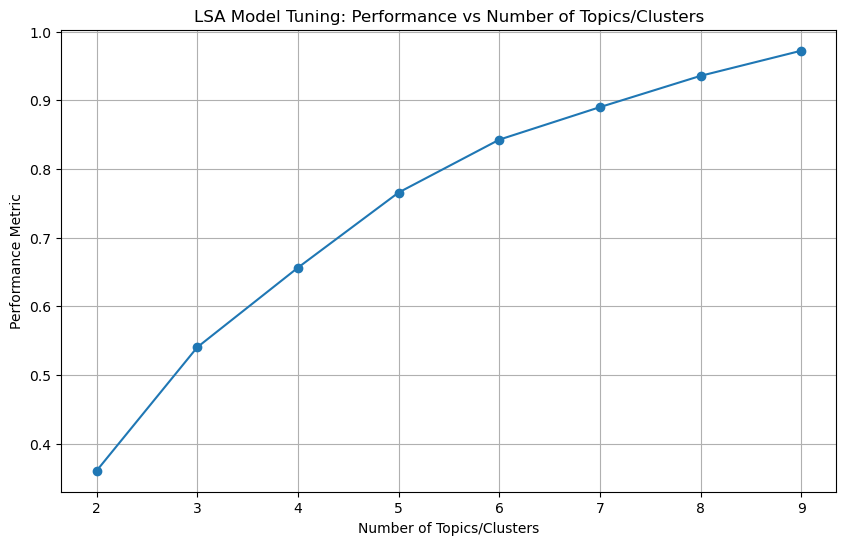

In [35]:
performance_scores_lsa = tune_model_performance(dtm_tfidf, algorithm='LSA', n_range=range(2, 10), random_state=42)

Tuning the number of clusters/topics for LDA:
Number of topics: 2, Perplexity: 11567.85
Number of topics: 3, Perplexity: 11757.16
Number of topics: 4, Perplexity: 11671.22
Number of topics: 5, Perplexity: 12019.35
Number of topics: 6, Perplexity: 11941.74
Number of topics: 7, Perplexity: 12005.73
Number of topics: 8, Perplexity: 12022.50
Number of topics: 9, Perplexity: 12127.61


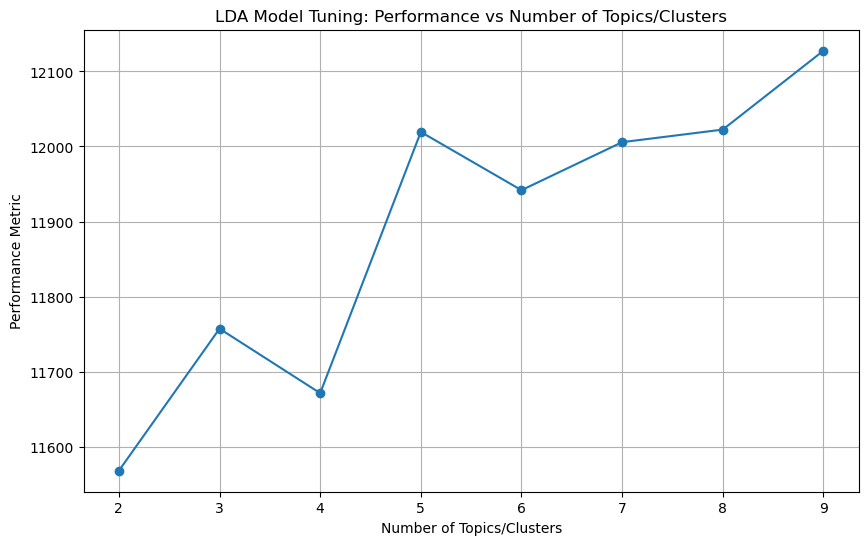

In [36]:
performance_scores_lda = tune_model_performance(dtm_bow, algorithm='LDA', n_range=range(2, 10), random_state=42)

Tuning the number of clusters/topics for NMF:
Number of topics: 2, Reconstruction Error: 1.96
Number of topics: 3, Reconstruction Error: 1.68
Number of topics: 4, Reconstruction Error: 1.45
Number of topics: 5, Reconstruction Error: 1.19
Number of topics: 6, Reconstruction Error: 0.98
Number of topics: 7, Reconstruction Error: 0.83
Number of topics: 8, Reconstruction Error: 0.63
Number of topics: 9, Reconstruction Error: 0.41


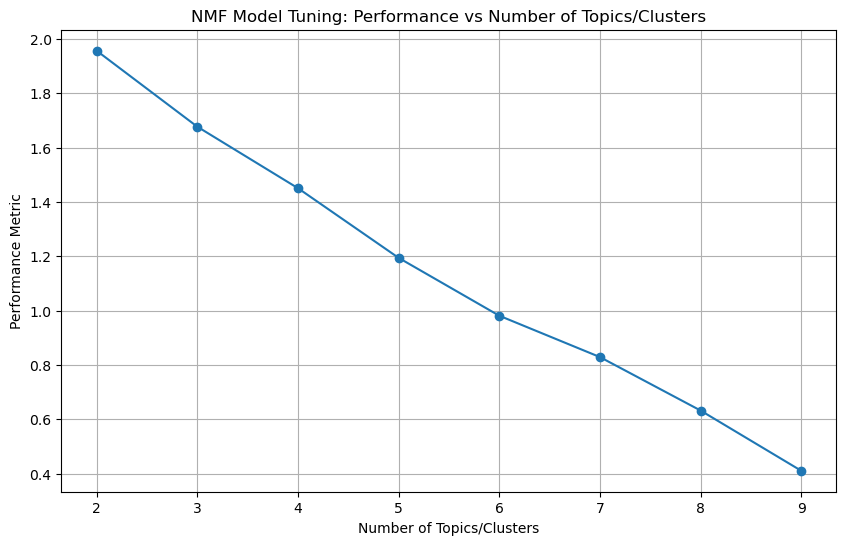

In [37]:
performance_scores_nmf = tune_model_performance(dtm_tfidf, algorithm='NMF', n_range=range(2, 10), random_state=42)

Tuning the number of clusters/topics for KMeans:
Number of clusters: 2, Silhouette Score: 0.27
Number of clusters: 3, Silhouette Score: 0.19
Number of clusters: 4, Silhouette Score: 0.19
Number of clusters: 5, Silhouette Score: 0.19
Number of clusters: 6, Silhouette Score: 0.18
Number of clusters: 7, Silhouette Score: 0.16
Number of clusters: 8, Silhouette Score: 0.17
Number of clusters: 9, Silhouette Score: 0.11


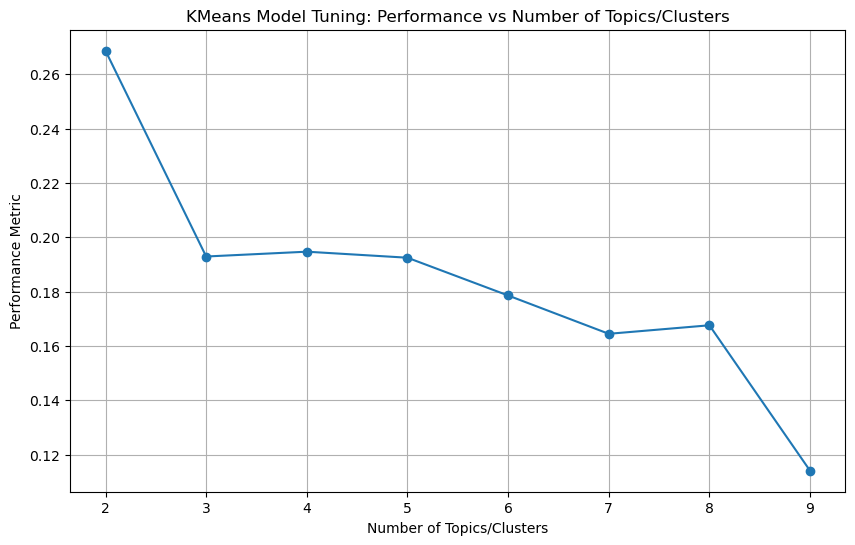

In [38]:
performance_scores_kmeans = tune_model_performance(dtm_tfidf, algorithm='KMeans', n_range=range(2, 10), random_state=42)